In [1]:
import polars as pl
import hvplot.polars

In [2]:
df = pl.read_csv("data/processed/final_news_data.csv").unique()

In [15]:
company = df.filter((pl.col("permco") == 1015) & (pl.col('Article_title').is_not_null()))  

In [16]:
articles = company.select('Article_title')

In [35]:
company_iti = company.filter(pl.col('ITI(13D)') > 0.9)

articles_iti = company_iti.select('Article_title')

company_not_iti = company.filter(pl.col('ITI(13D)') < 0.1)
articles_not_iti = company_not_iti.select('Article_title')

In [25]:
import re
from wordcloud import STOPWORDS

text = ' '.join(articles.to_series())

text = re.sub(r'[^A-Za-z\s]', '', text)

text = text.lower()

stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

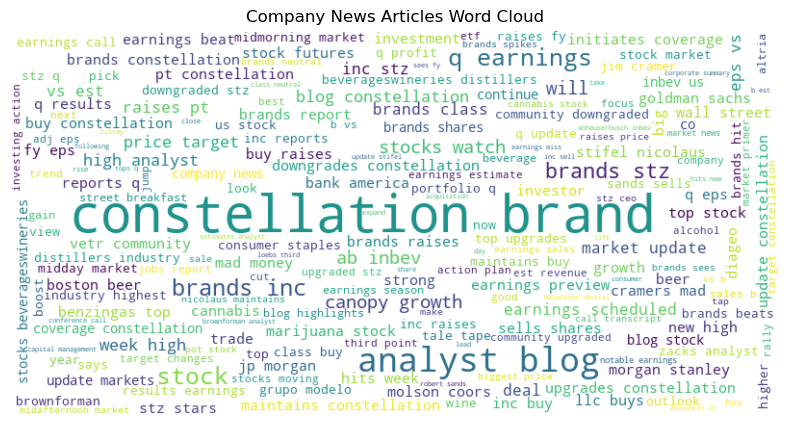

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Company News Articles Word Cloud")
plt.show()

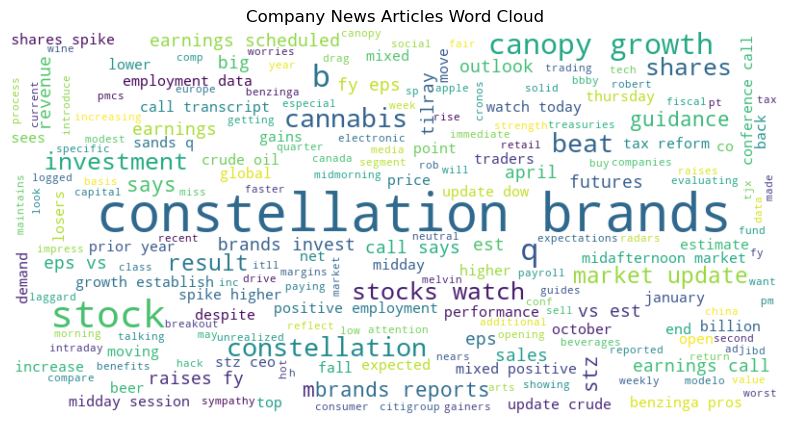

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from wordcloud import STOPWORDS

text = ' '.join(articles_iti.to_series())

text = re.sub(r'[^A-Za-z\s]', '', text)

text = text.lower()

stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Company News Articles Word Cloud")
plt.show()

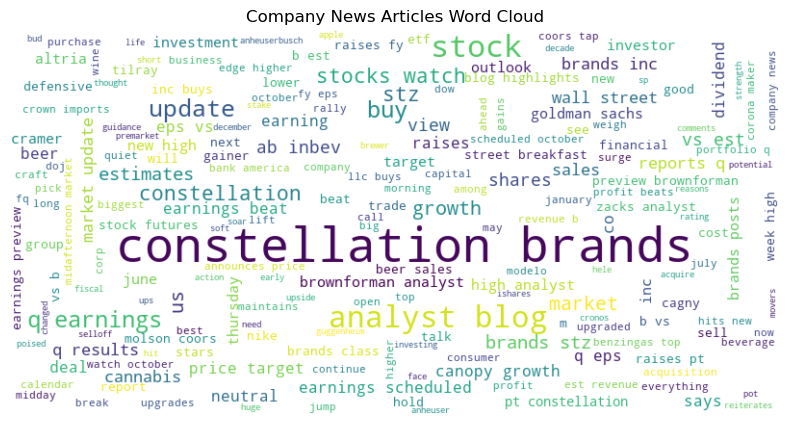

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from wordcloud import STOPWORDS

text = ' '.join(articles_not_iti.to_series())

text = re.sub(r'[^A-Za-z\s]', '', text)

text = text.lower()

stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Company News Articles Word Cloud")
plt.show()

In [37]:
df_news = pl.read_csv("data/processed/financial_sentiment_analysis.csv")
df_news = df_news.unique()

In [40]:
import polars as pl

# --- Load and clean the data ---

# Read the sentiment dataset and remove duplicate rows
df_news = pl.read_csv("data/processed/financial_sentiment_analysis.csv").unique()

# Read the processed news dataset and remove duplicates as well
df = pl.read_csv("data/processed/final_news_data.csv").unique()

# Keep only rows with a valid article title
df_articles = (
    df.filter(pl.col("Article_title").is_not_null())
      .select("date", "comnam", "Article_title")
)

# --- Merge datasets ---

# Join the articles with their corresponding sentiment data
# Match by (date, company name, and article title)
news_df = (
    df_articles.join(
        df_news,
        left_on=["date", "comnam", "Article_title"],
        right_on=["date", "comnam", "Headline"],
        how="inner"
    ).unique()
)

# Merge sentiment info into the main dataset
final_df = (
    df.join(news_df, on=["date", "comnam", "Article_title"], how="left")
      .unique(subset=["date", "comnam", "Article_title"])
)

# --- Feature engineering ---

# Compute next-day return and clean the data
filter_df = (
    final_df.with_columns(pl.col("ret").shift(-1).alias("next_day_ret"))
             .sort(["permco", "date"])
             .drop_nulls(subset=["ITI(13D)", "next_day_ret"])
)

# Replace null sentiment columns with 0 before computing the score
filter_df = filter_df.with_columns([
    pl.col("Positive").fill_null(0),
    pl.col("Negative").fill_null(0)
])

# Compute sentiment score = Positive - Negative
filter_df = filter_df.with_columns(
    (pl.col("Positive") - pl.col("Negative")).alias("sentiment_score")
)

# Keep only the relevant columns
filter_df = filter_df.select([
     "permco", "date", "ITI(13D)", "sentiment_score", "next_day_ret", 'vol', 'on_rdq', 'Article_title'
])

# Convert date column to Date type
filter_df = filter_df.with_columns(
    pl.col("date").str.strptime(pl.Date, "%Y-%m-%d").alias("date")
)

# Remove zeros in sentiment score
#filter_df = filter_df.filter(pl.col("sentiment_score") != 0)

# Rename ITI column for easier access in statsmodels
filter_df = filter_df.rename({"ITI(13D)": "ITI"})

filter_df

permco,date,ITI,sentiment_score,next_day_ret,vol,on_rdq,Article_title
i64,date,f64,f64,f64,f64,i64,str
7,2009-05-27,0.152583,0.0,0.008961,2.3715964e7,0,null
7,2009-05-28,0.261909,0.0,0.01225,1.8010434e7,0,null
7,2009-05-29,0.096691,0.0,0.0125,1.6735245e7,0,null
7,2009-06-01,0.089552,0.0,-0.048611,1.6721281e7,0,null
7,2009-06-02,0.018411,0.0,0.004533,1.6765453e7,0,null
…,…,…,…,…,…,…,…
58620,2009-08-25,0.319228,0.0,-0.012931,6874.0,0,null
58620,2009-08-26,0.114453,0.0,-0.008972,4432.0,0,null
58620,2009-08-27,0.215733,0.0,-0.016762,15060.0,0,null


In [41]:
company_filter = filter_df.filter((pl.col("permco") == 1015) & (pl.col('Article_title').is_not_null()))  

In [50]:
positive_sentiment_articles = company_filter.filter(pl.col("sentiment_score") > 0.9).select('Article_title')
negative_sentiment_articles = company_filter.filter(pl.col("sentiment_score") < -0.9).select('Article_title')

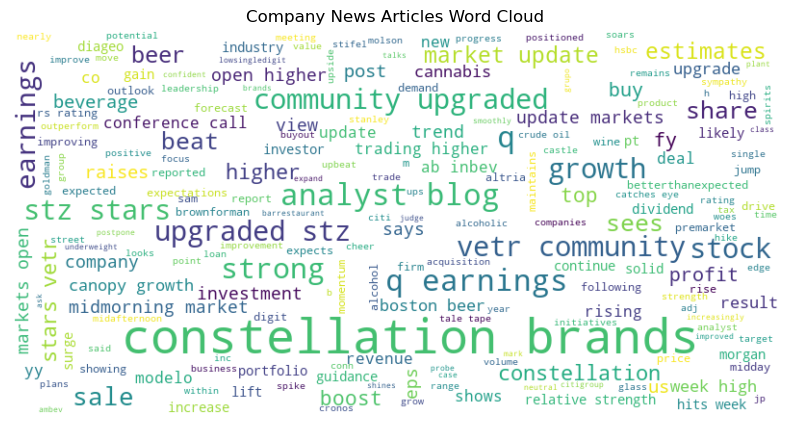

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from wordcloud import STOPWORDS

text = ' '.join(positive_sentiment_articles.to_series())

text = re.sub(r'[^A-Za-z\s]', '', text)

text = text.lower()

stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Company News Articles Word Cloud")
plt.show()

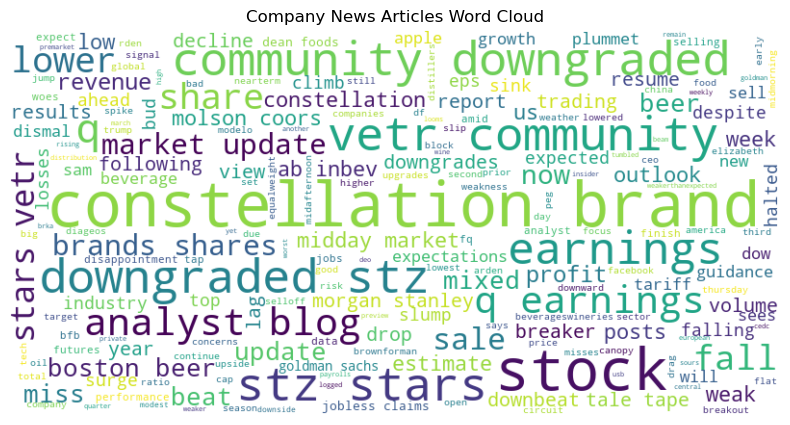

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from wordcloud import STOPWORDS

text = ' '.join(negative_sentiment_articles.to_series())

text = re.sub(r'[^A-Za-z\s]', '', text)

text = text.lower()

stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Company News Articles Word Cloud")
plt.show()